Austin Feydt (apf31)

EECS 531 - A1

21 February 2018

# Exercise 1: Blurring Filters

# Mathematical Background:

In image processing, a filter is a mapping that modifies an image in any number of ways, ranging from feature enhancement to image sharpening.  Among these filters includes a blurring filter. Blurring is often used as a preprocessing technique in image processing, as it reduces noise in the image.

&nbsp;

Blurring filters reduce the details in an image by mapping each pixel in the image to a convolution of a kernel matrix and the surrounding pixels of the original image. For any two matrices

&nbsp;

$$A = \begin{bmatrix}
a & b & c\\
d & e & f\\
g & h & i
\end{bmatrix}, 
B = \begin{bmatrix}
1 & 2 & 3\\
4 & 5 & 6\\
7 & 8 & 9
\end{bmatrix}$$

we define the convolution as:
&nbsp;

$$A*B = (i*1) + (h*2) + (g*3) + (f*4) + (e*5) + (d*6) + (c*7) + (b*8) + (a*9)$$
(notice that, in practice, the kernel is first flipped vertically and horizontally.)

&nbsp;

Thus, to apply a filter to an image, we must choose a kernel, and then apply this convolution to every possible submatrix of the image matrix to generate a new, filtered image. I will be implementing the following gaussian filter kernel:
&nbsp;

$$\frac{1}{256} 
\begin{bmatrix}
1 & 4 & 6 & 4 & 1\\
4 & 16 & 24 & 16 & 4\\
6 & 24 & 36 & 24 & 6\\
4 & 16 & 24 & 16 & 4\\
1 & 4 & 6 & 4 & 1
\end{bmatrix}$$

&nbsp;

This filter kernel incorporates higher weights towards the center of the local set of pixels, and less weight to the outer pixels.  Also, since it is linearly separable $(K=vh^T)$, computing our convolution as sequential 1D convolutions $(X*v)*h^T$ will reduce runtime from quadratic to just linear (with respect to the kernel size).  Luckily, our 2D gaussian kernel reduces to a simple 1D kernel:
&nbsp;

$$v= h = \frac{1}{16}
\begin{bmatrix}
1\\
4\\
6\\
4\\
1
\end{bmatrix}$$
&nbsp;

Before we apply our kernel to an image, we must explore how to handle the edges of the image.  If we try to apply this kernel to the edges of our image, we will run into out-of-bounds errors.  The easiest way to handle this is to "pad" our image, in which we increase the pixel width and height by half of the width/height of our kernel by adding extra black pixels around the image, so that we can center our kernel around edge pixels:

# Implementation:

In [70]:
from skimage import io, color
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Adds black pixels around the border of the picture
def pad_image(image, kernel_width, kernel_height):
    delta_width = kernel_width // 2
    delta_height = kernel_height // 2
    
    padding = max(delta_width, delta_height)
    padded_image = np.zeros((image.shape[0] + 2*padding, image.shape[1] + 2*padding))   
    
    # overlay image into submatrix of the larger padded_image matrix
    padded_image[padding:-padding, padding:-padding] = image
    return padded_image

# Blurs the orig_image within the pad_image with the given 2D kernel
def blur_2d_conv(orig_image, pad_image, kernel):
    
    # Flip the kernel properly
    kernel = np.flipud(np.fliplr(kernel))  
    
    # find the offset of the inner image
    shift = kernel.shape[0]

    output = np.zeros_like(orig_image) 
    
    # Loop through every pixel in the inner image
    for x in range(orig_image.shape[1]):     
        for y in range(orig_image.shape[0]):
            # Perform 2D convolution
            t = two_dim_conv(kernel, pad_image[y:y+shift,x:x+shift])
            print(t)
            sys.exit()

            output[y,x] = two_dim_conv(kernel, pad_image[y:y+shift,x:x+shift])
    return output

# Blurs the orig_image within the pad_image with the given 1D kernel generator
def blur_sep_conv(orig_image, pad_image, generator):
    
    # Find the offset of the inner image
    shift = generator.shape[0]
    
    output = np.zeros_like(orig_image) 
    
    # loop through every pixel in the inner image
    for x in range(orig_image.shape[1]):     
        for y in range(orig_image.shape[0]):
            # Perform sequential 1D convolutions (linear speedup from above blurring filter)
           # t = separable_conv(generator, pad_image[y:y+shift,x:x+shift])
            #print('hey')
            #print(t)
            #sys.exit()
            output[y,x] = separable_conv(generator, pad_image[y:y+shift,x:x+shift])
    return output

# convolves the two matrices
def two_dim_conv(kernel, sub_matrix):
    output = (kernel*sub_matrix).sum()
    return output

# Uses separable 1D convolutions, where generator*(generator)^T = kernel
def separable_conv(generator, sub_matrix):
    # performs X = Image*generator (* is conv)
    first_conv = sub_matrix * generator[:, np.newaxis]
    first_conv = np.sum(first_conv, axis=0)
    
    #performs X*generator^T (* is conv)
    generator_T = np.transpose(generator)
    second_conv = np.multiply(first_conv, generator_T)
    
    output = np.sum(second_conv)
    return output

Original Image:


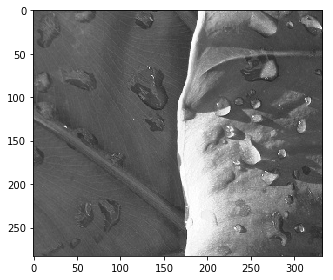

Padded Image:


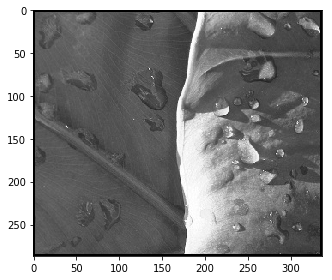

Blurred using 2D convolution:


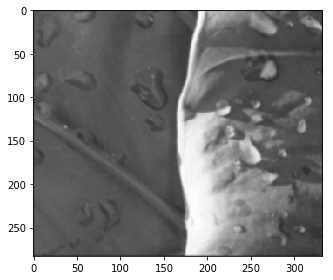

Blurred using separable kernel:


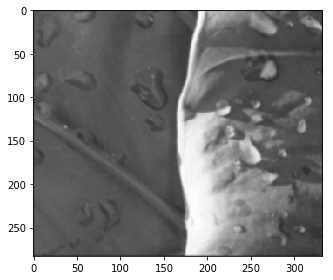

In [80]:
# Preprocessing
image = io.imread('A1_images/leaf.png')
image = color.rgb2gray(image)
print("Original Image:")
io.imshow(image)
io.show()

#Pad the image and save it
padded_image = pad_image(image, 5, 5)
print("Padded Image:")
io.imshow(padded_image)
io.show()


#Create kernel and corresponding generator
kernel = (1/256.0) * np.array([[1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4],[1,4,6,4,1]])
generator = (1/16.0) * np.array([1,4,6,4,1])

#Blur using 2D convolution
blurred_image = blur_2d_conv(image,padded_image, kernel)
print("Blurred using 2D convolution:")
io.imshow(blurred_image)
io.show()

#Blur using separable kernel
sep_blurred_image = blur_sep_conv(image,padded_image,generator)
print("Blurred using separable kernel:")
io.imshow(sep_blurred_image)
io.show()



# Exploratory Results:

After applying both flavors of blurring (2D convolution and separable kernel convolution) to our original leaf image, we can see the image becomes much less detailed.  Original sharp lines (like the edges of water droplets and texture of the leaf) are smoothed over, making the image less prone to having strong noise signals. However, one may be interested in blurring their image multiple times, depending on what they are trying to do with their image.  As we can see below, after blurring the already blurred image, edges continue to fade away.  And after 50 blurs, the image is basically unidentifiable.  However, interestingly enough, the light contrast in the original image (the center sliver being light, while the rest of the image is in a shadow), still remains prevalent in the heavily blurred image.  This suggests that perhaps blurring is not an appropriate filter to use if one is interested in changing the brightness/shadows in a photo.

Blurred twice:


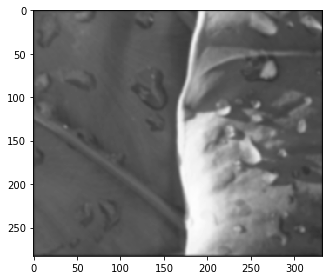

Blurred 50 times:


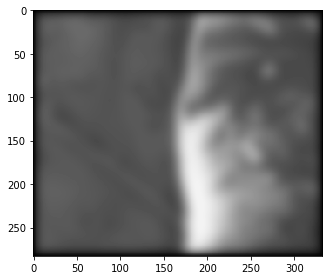

In [81]:
blurred_image = blur(image, pad_image(blurred_image,5,5), kernel)
print("Blurred twice:")
io.imshow(blurred_image)
io.show()

for y in range(0,48):
    blurred_image = blur(image, pad_image(blurred_image,5,5), kernel)
    
print("Blurred 50 times:")
io.imshow(blurred_image)
io.show()